# 🗞️ Task 1 – News Sentiment EDA  
📘 Version: 2025-05-29

Exploratory Data Analysis (EDA) of financial news headlines to extract publishing trends, text characteristics, and early sentiment signals for stock prediction modeling.

### This notebook covers:
- Headline length and word stats
- Publisher activity and domain extraction
- Time-based publishing patterns
- Early keyword/sentiment cues
- Cleaned export for sentiment modeling


In [67]:
# 🛠 Ensure notebook runs from project root if launched from /notebooks/
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
print("📂 Working directory is now:", os.getcwd())

expected_file = "data/raw_analyst_ratings.csv"  # Replace with actual path once confirmed
print("📄 File found" if os.path.exists(expected_file) else "🚫 File NOT found!", expected_file)


📂 Working directory is now: c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge
📄 File found data/raw_analyst_ratings.csv


In [68]:
# ------------------------------------------------------------------------------
# 📦 Core Libraries
# ------------------------------------------------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------------------
# 🧠 NLP & Text Processing
# ------------------------------------------------------------------------------
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Fuzzy string matching for keyword detection
from rapidfuzz import fuzz, process

# ------------------------------------------------------------------------------
# 🔧 Display & Config
# ------------------------------------------------------------------------------
from IPython.display import display

# ------------------------------------------------------------------------------
# ⚙️ Optional: Download NLTK resources if running for first time
# ------------------------------------------------------------------------------
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 📥 Load Financial News Dataset

This step initializes the core dataset used throughout the EDA pipeline:

- Loads `raw_analyst_ratings.csv` from the `data/` directory.
- Automatically parses the `date` column (UTC) into a datetime format.
- Provides a clean wrapper around `pandas.read_csv()` via a modular `NewsDataLoader` class.
- Includes verbose output to verify encoding, shape, and column schema.

This ensures a robust and reproducible starting point for downstream feature engineering and sentiment modeling.


In [69]:
# ------------------------------------------------------------------------------
# 📥 Load Financial News Dataset
# ------------------------------------------------------------------------------

from src.news_loader import NewsDataLoader

# Define the dataset path (already confirmed to exist in repo)
DATA_PATH = "data/raw_analyst_ratings.csv"

# Initialize loader (auto-parses 'date' column and prints summary if verbose=True)
try:
    loader = NewsDataLoader(path=DATA_PATH)
    df = loader.load()
except Exception as e:
    print(f"❌ Failed to load dataset: {e}")
    df = None  # gracefully degrade for further diagnosis



📄 File loaded: data/raw_analyst_ratings.csv
📦 Encoding used: utf-8
🔢 Rows: 1,407,328 | Columns: 6
🧪 Columns: Unnamed: 0, headline, url, publisher, date, stock



## ✅ Initial Sanity Checks – Structure, Missingness, Duplicates

Before diving into analysis, we run a quick diagnostic to verify data health:

- Preview the top 3 rows for structural validation.
- Print full column data types to confirm schema expectations.
- Check for missing values across all columns.
- Identify and count any fully duplicated rows.

These checks help detect formatting issues or corrupt entries early, ensuring downstream feature engineering operates on clean and consistent data.


In [70]:
# ------------------------------------------------------------------------------
# ✅ Initial Sanity Check – Columns, Types, and Nulls
# ------------------------------------------------------------------------------

if df is not None:
    # Show a snapshot of the dataset
    display(df.head(3))

    # Column data types
    print("🧬 Column Data Types:")
    print(df.dtypes)

    # Check for missing values in key columns
    print("\n🔍 Missing Value Summary:")
    missing = df.isna().sum()
    print(missing[missing > 0] if missing.any() else "✅ No missing values detected.")

    # Check for duplicate rows (safety check for merge logic later)
    duplicate_count = df.duplicated().sum()
    if duplicate_count > 0:
        print(f"⚠️ Found {duplicate_count:,} duplicate rows.")
    else:
        print("✅ No duplicate rows found.")

else:
    print("🚫 Skipping diagnostics – DataFrame not loaded.")


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A


🧬 Column Data Types:
Unnamed: 0     int64
headline      object
url           object
publisher     object
date          object
stock         object
dtype: object

🔍 Missing Value Summary:
✅ No missing values detected.
✅ No duplicate rows found.


## ⏰ Robust Timestamp Cleaning – Preprocessing & Parsing

Before performing any time-based feature engineering, we clean and normalize the raw timestamp data to ensure consistent, timezone-aware datetime values.

- Coerce timestamps into a uniform datetime format with error handling.
- Trim whitespace and detect invisible Unicode characters that may break parsing.
- Log parsing success rates and sample failures for diagnostics.
- Add a new `cleaned_date` column to be used in all downstream time analyses.

This step is critical to avoid cascading errors and maximize the reliability of temporal insights.


In [71]:
# ------------------------------------------------------------------------------
# ⏰ Robust Timestamp Cleaning with Summary and Diagnostics
# ------------------------------------------------------------------------------

from src.text_timestamp_cleaner import TimestampCleaner

# Instantiate the timestamp cleaner with verbose diagnostics enabled
ts_cleaner = TimestampCleaner(verbose=True)

# Clean and parse the raw 'date' column, producing a new 'cleaned_date' column
df = ts_cleaner.clean(df)

# Print summary stats
total_rows = len(df)
parsed_count = df["cleaned_date"].notna().sum()
failed_count = df["cleaned_date"].isna().sum()

print(f"\n📅 Timestamp Cleaning Summary:")
print(f"  - Total rows processed: {total_rows:,}")
print(f"  - Successfully parsed timestamps: {parsed_count:,}")
print(f"  - Failed parses (NaT): {failed_count:,}")

# Show sample failed original timestamps for diagnosis (if any)
if failed_count > 0:
    failed_samples = df.loc[df["cleaned_date"].isna(), "date"].unique()[:5]
    print("\n⚠️ Sample failed original timestamps:")
    for ts in failed_samples:
        print(f"  - {repr(ts)}")

# Display first few cleaned timestamps side by side with original
print("\n✅ Sample cleaned timestamps:")
print(df[["date", "cleaned_date"]].head(5).to_string(index=False))


TimestampCleaner Summary:
Total rows processed:    1,407,328
Successfully parsed:     1407328
Failed parses (NaT):     0

Source value types:
  - str: 1407328


📅 Timestamp Cleaning Summary:
  - Total rows processed: 1,407,328
  - Successfully parsed timestamps: 1,407,328
  - Failed parses (NaT): 0

✅ Sample cleaned timestamps:
                     date cleaned_date
2020-06-05 10:30:54-04:00   2020-06-05
2020-06-03 10:45:20-04:00   2020-06-03
2020-05-26 04:30:07-04:00   2020-05-26
2020-05-22 12:45:06-04:00   2020-05-22
2020-05-22 11:38:59-04:00   2020-05-22


## 🧼 Cleaned Text Column

This step applies a configurable text cleaning pipeline to remove:
- HTML tags (e.g., `<br>`)
- Escape characters (`&amp;`)
- Punctuation
- Stopwords (e.g., "the", "and")

The result is saved as a new column `cleaned_headline` for further NLP and sentiment modeling.

In [72]:

# ------------------------------------------------------------------------------
# 🧼 Text Cleaning – remove HTML, normalize casing, etc.
# ------------------------------------------------------------------------------

from src.text_cleaner import TextCleaner

# Initialize cleaner with common config
cleaner = TextCleaner(
    text_col="headline",
    output_col="cleaned_headline",
    lowercase=True,
    remove_html=True,
    remove_punctuation=True,
    remove_stopwords=True,
    verbose=True,
)

# Apply transformation
try:
    df = cleaner.transform(df)
except Exception as e:
    print(f"❌ Cleaning failed: {e}")


✅ Column 'cleaned_headline' successfully added.
🔍 Sample Before → After:
  - Stocks That Hit 52-Week Highs On Friday
    → stocks hit 52week highs friday
  - Stocks That Hit 52-Week Highs On Wednesday
    → stocks hit 52week highs wednesday
  - 71 Biggest Movers From Friday
    → 71 biggest movers friday
🧼 Nulls replaced: 0


## 📊 Descriptive Statistics – Headline Features, Publisher Frequencies & Publication Dates

This section performs key descriptive analytics on the news headlines and their metadata, extracting critical structural and temporal insights:

- **Headline length**: Number of characters per headline (including punctuation and whitespace).
- **Word count**: Total token count per headline, leveraging NLTK’s tokenizer for accurate word boundaries.
- **Publisher activity**: Counts the number of articles contributed by each publisher, identifying the most prolific sources.
- **Publication date distribution**: Aggregates and analyzes article counts across publication dates to reveal temporal trends.

These foundational metrics inform downstream sentiment modeling and time series analyses while ensuring data quality and coverage transparency.


✅ Text features added:
📊 Input column: 'headline'
🔠 headline_length (chars): {'count': 1407328.0, 'mean': 73.12051490484095, 'std': 40.73530993195065, 'min': 3.0, '25%': 47.0, '50%': 64.0, '75%': 87.0, 'max': 512.0}
🗨️ word_count (tokens): {'count': 1407328.0, 'mean': 13.676373240637577, 'std': 8.452906660503414, 'min': 1.0, '25%': 8.0, '50%': 12.0, '75%': 16.0, 'max': 100.0}
✅ Found 1034 unique publishers.
📈 Top 10 publishers by article count:


,publisher,article_count
0,Paul Quintaro,228373
1,Lisa Levin,186979
2,Benzinga Newsdesk,150484
3,Charles Gross,96732
4,Monica Gerson,82380
5,Eddie Staley,57254
6,Hal Lindon,49047
7,ETF Professor,28489
8,Juan Lopez,28438
9,Benzinga Staff,28114



📊 Top 10 Publishers by Article Count:


,publisher,article_count
0,Paul Quintaro,228373
1,Lisa Levin,186979
2,Benzinga Newsdesk,150484
3,Charles Gross,96732
4,Monica Gerson,82380
5,Eddie Staley,57254
6,Hal Lindon,49047
7,ETF Professor,28489
8,Juan Lopez,28438
9,Benzinga Staff,28114


c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_publishers.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_publishers.py:162: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  Raises:
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\stock-market-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


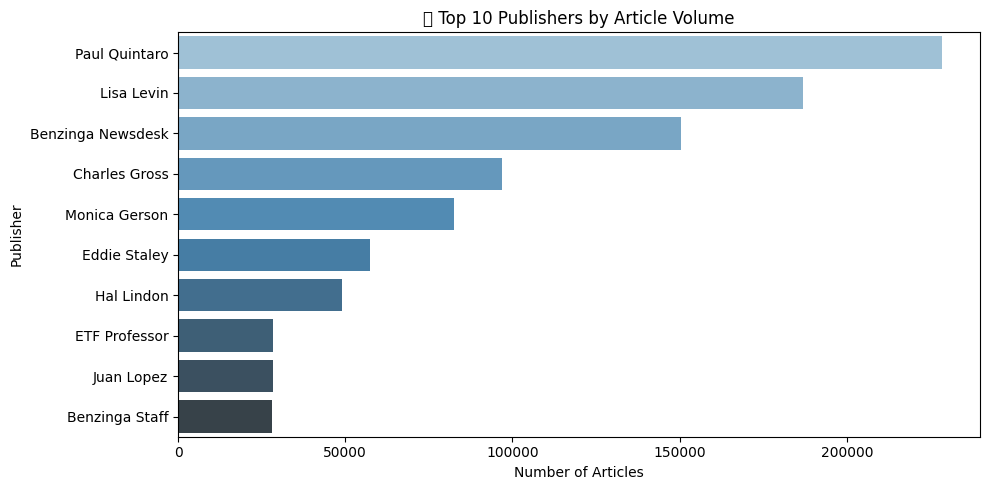

📊 Chart rendered for top 10 publishers.
✅ Computed article counts over 3955 dates.
🔍 Sample of publication date counts:


,cleaned_date,article_count
0,2009-02-14,1
1,2009-04-27,2
2,2009-04-29,1
3,2009-05-22,1
4,2009-05-27,6



✅ Computed article counts over 3955 unique dates.
🔍 Sample of publication date counts:


,cleaned_date,article_count
0,2009-02-14,1
1,2009-04-27,2
2,2009-04-29,1
3,2009-05-22,1
4,2009-05-27,6
5,2009-05-29,2
6,2009-05-30,3
7,2009-06-01,5
8,2009-06-02,2
9,2009-06-05,6


c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_publishers.py:288: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\stock-market-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


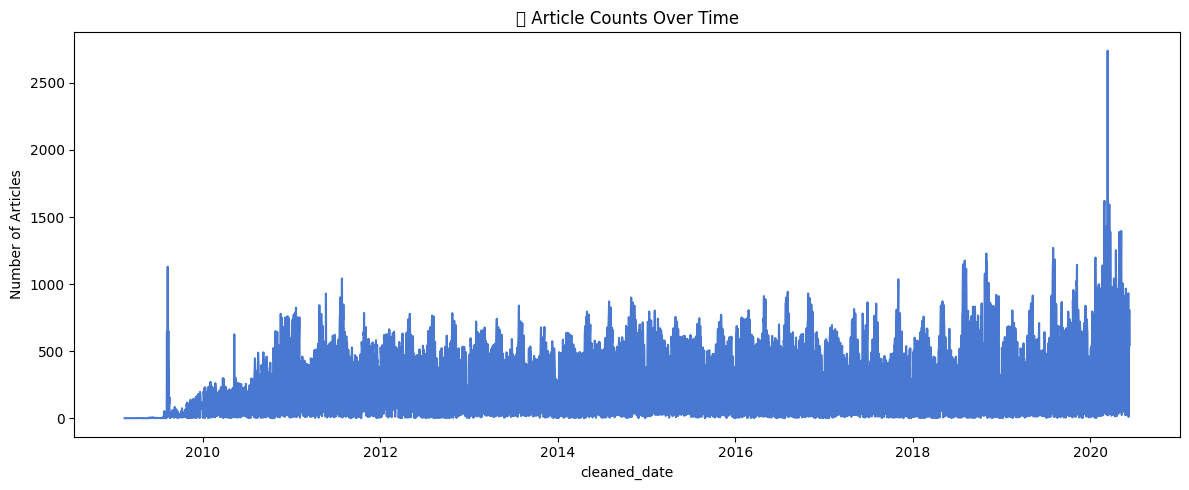

📊 Publication date frequency chart rendered successfully.


In [73]:
# ------------------------------------------------------------------------------
# 📊 Descriptive Statistics – Publisher Frequencies & Publication Date Counts
# ------------------------------------------------------------------------------

from src.text_features import TextFeatureExtractor
from src.text_publishers import PublisherAnalyzer

# Initialize feature extractor for headline length and word count
feature_extractor = TextFeatureExtractor(headline_col="headline", verbose=True)

# Initialize publisher analyzer with verbosity for diagnostics
publisher_analyzer = PublisherAnalyzer(publisher_col="publisher", verbose=True)

try:
    # Extract headline length and word count features
    df = feature_extractor.transform(df)

    # Compute article counts per publisher and store results internally
    publisher_freq_df = publisher_analyzer.analyze(df, top_n=10)

    # Print heading for clarity
    print("\n📊 Top 10 Publishers by Article Count:")

    # Use environment-agnostic display helper method to show frequency table
    publisher_analyzer._display(publisher_freq_df.head(10))

    # Plot top 10 publishers by article volume
    publisher_analyzer.plot_top_publishers(top_n=10)

    # Aggregate article counts by publication date (expects cleaned datetime column)
    pub_date_counts_df = publisher_analyzer.analyze_publication_dates(
        df, date_col="cleaned_date"
    )

    # Print count summary and sample preview of publication dates
    print(
        f"\n✅ Computed article counts over {pub_date_counts_df.shape[0]} unique dates."
    )
    print("🔍 Sample of publication date counts:")
    publisher_analyzer._display(pub_date_counts_df.head(10))

    # Plot article counts over time as a line chart
    publisher_analyzer.plot_publication_dates(pub_date_counts_df)

except Exception as e:
    # Catch-all for errors in descriptive statistics computation or plotting
    print(f"❌ Error during descriptive statistics extraction: {e}")

## 📊 Headline Length & Word Count Distributions

This visualization shows the structural distribution of headlines:
- **Character Length:** Total characters per headline (`headline_length`)
- **Word Count:** Number of tokens per headline (`word_count`)

These insights help validate text normalization and highlight outliers (e.g., abnormally short or long headlines).


✅ Columns validated: headline_length, word_count
🎨 Style applied: seaborn-v0_8-muted


c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_distributions.py:150: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to prevent overlap
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\stock-market-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


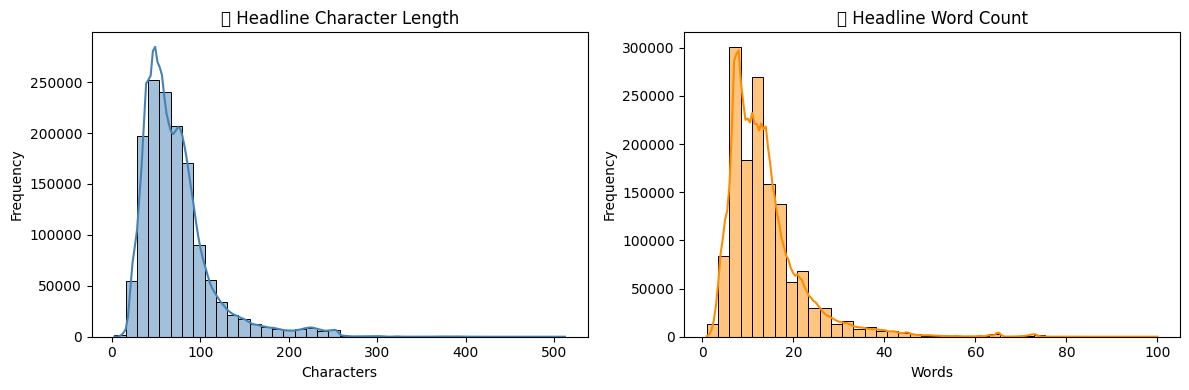

📈 Distribution plots rendered successfully.


In [74]:
# ------------------------------------------------------------------------------  
# 📊 Visualize Headline Text Distributions – Length & Word Count  
# ------------------------------------------------------------------------------

from src.text_distributions import TextDistributionPlotter

# Initialize the plotter
plotter = TextDistributionPlotter(
    length_col="headline_length",
    word_col="word_count",
    bins=40,
    title_prefix="📝",
    style="seaborn-v0_8-muted",
    use_latex_style=False,
    verbose=True,
)

# Safely plot distribution histograms
try:
    plotter.plot(df, show=True)
except Exception as e:
    print(f"❌ Failed to render text distribution plots: {e}")


## 🏢 Publisher Frequency Analysis

Analyzes the number of headlines published by each media outlet.  
Highlights the most prolific sources in the dataset and helps assess coverage concentration or potential bias.

✅ Found 1034 unique publishers.
📈 Top 10 publishers by article count:


,publisher,article_count
0,Paul Quintaro,228373
1,Lisa Levin,186979
2,Benzinga Newsdesk,150484
3,Charles Gross,96732
4,Monica Gerson,82380
5,Eddie Staley,57254
6,Hal Lindon,49047
7,ETF Professor,28489
8,Juan Lopez,28438
9,Benzinga Staff,28114


c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_publishers.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_publishers.py:162: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  Raises:
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\stock-market-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


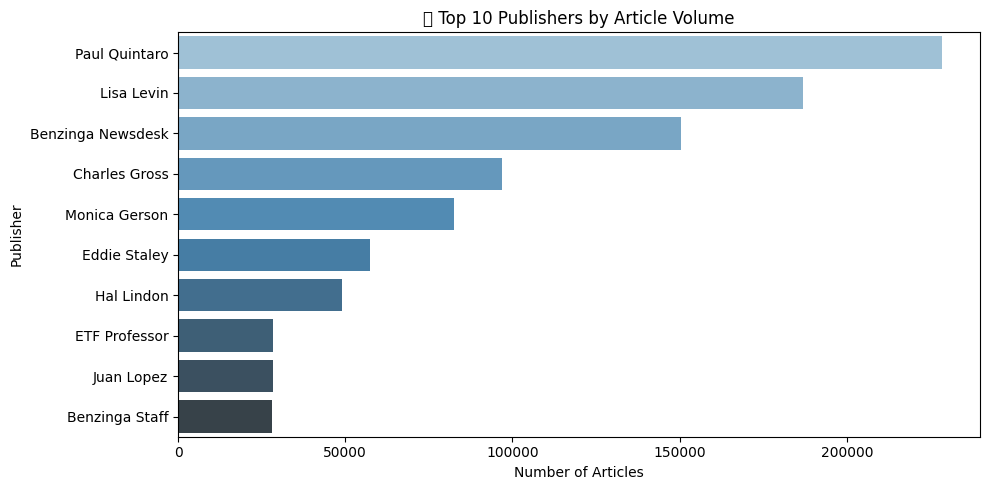

📊 Chart rendered for top 10 publishers.


In [75]:
# ------------------------------------------------------------------------------  
# 📰 Publisher Frequency Analysis
# ------------------------------------------------------------------------------

from src.text_publishers import PublisherAnalyzer  # ✅ correct class name

# Initialize analysis object
try:
    publisher_analyzer = PublisherAnalyzer(
        publisher_col="publisher",
        verbose=True
    )

    # Analyze publisher frequency
    publisher_freq_df = publisher_analyzer.analyze(df)

    # Plot top publishers
    publisher_analyzer.plot_top_publishers(top_n=10)

except Exception as e:
    print(f"❌ Publisher frequency analysis failed: {e}")


## 🌐 Publisher Domain Extraction

Extracts and groups publisher URLs or names into standardized domain patterns (e.g., `yahoo.com`).  
Useful for identifying bots, conglomerates, and repeated sources behind different brand names.


✅ Domain analysis complete on column 'url'
🔢 1 unique domains found.
📈 Top 10 domains:


,publisher_domain,article_count
0,benzinga.com,1407328


📋 Columns in top_data: ['publisher_domain', 'article_count']
  publisher_domain  article_count
0     benzinga.com        1407328


c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_publishers_domains.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_publishers_domains.py:182: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\stock-market-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


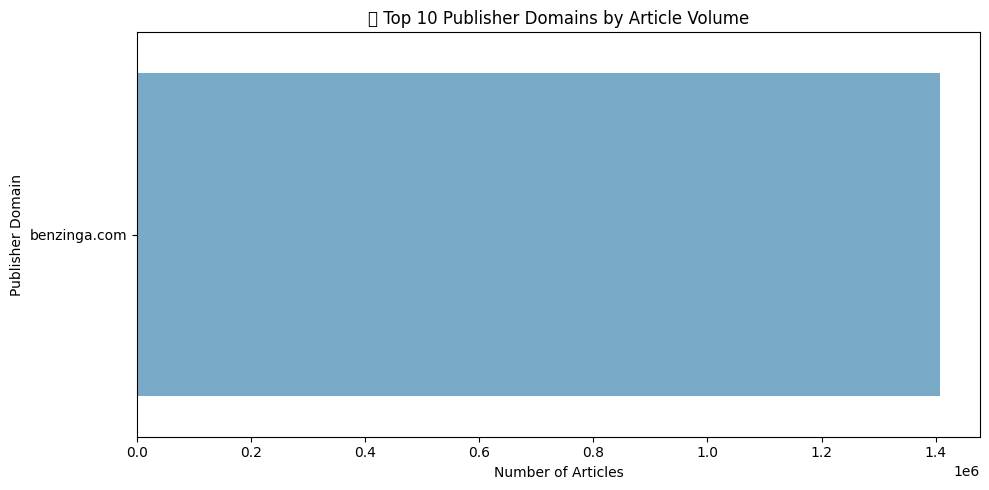

📊 Rendered bar chart for top 10 domains.


In [76]:
# ------------------------------------------------------------------------------  
# 🌐 Publisher Domain Extraction  
# ------------------------------------------------------------------------------

from src.text_publishers_domains import PublisherDomainAnalyzer

try:
    domain_analyzer = PublisherDomainAnalyzer(
         publisher_col="url",
        domain_col="publisher_domain",
        verbose=True
    )

    # Run analysis and domain extraction
    df = domain_analyzer.analyze(df)

    # Plot top domains
    domain_analyzer.plot_top_domains(top_n=10)

except Exception as e:
    print(f"❌ Domain extraction failed: {e}")


## ⏱️ Time Series Analysis of News Volume

This section extracts:
- **Publication frequency over time** to identify periods of heavy news activity.
- **Weekday vs weekend bias** to detect institutional vs retail-driven publishing cycles.
- Useful for aligning market reactions and sentiment shifts with news density.


✅ Time features added: ['date_only', 'hour', 'day_of_week', 'is_weekend']
📅 Unique dates: 3955
🕒 Publishing hours: [19, 20]


c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_time_series.py:169: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to prevent clipping
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\stock-market-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


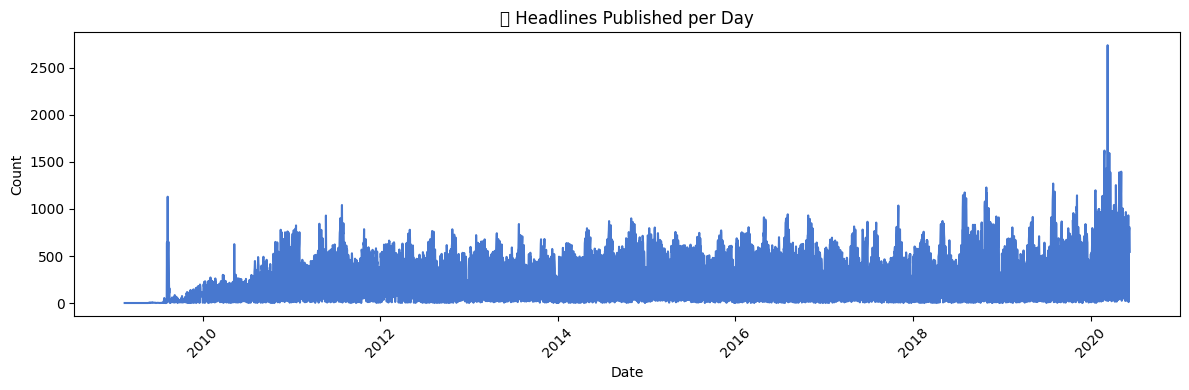

c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_time_series.py:193: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to prevent clipping
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\stock-market-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


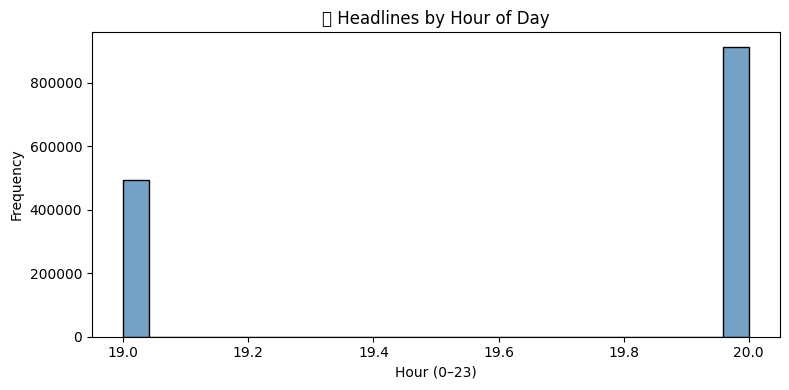

c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_time_series.py:220: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_time_series.py:226: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to prevent clipping
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\stock-market-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


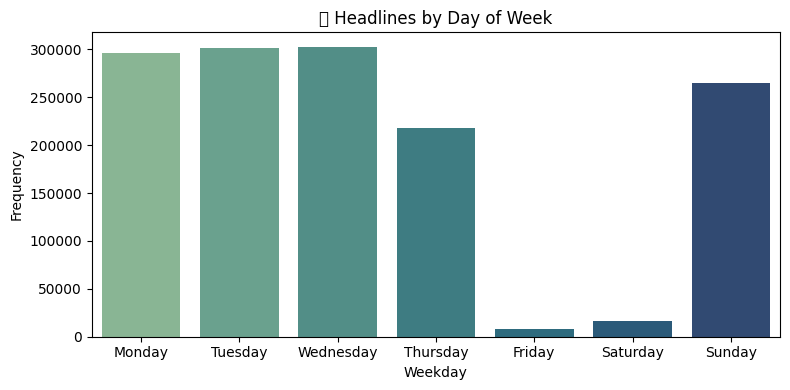

In [77]:
# ------------------------------------------------------------------------------
# 🕒 Time Series Analysis – Publishing Frequency and Weekday Patterns (using cleaned dates)
# ------------------------------------------------------------------------------

from src.text_time_series import TimeSeriesTextAnalyzer

try:
    # Initialize the analyzer with the cleaned_date column (output of TimestampCleaner)
    time_analyzer = TimeSeriesTextAnalyzer(
        date_col="cleaned_date",  # Use cleaned, timezone-normalized date column
        verbose=True,
    )

    # Apply time-based feature engineering and visualization
    df = time_analyzer.transform(df)  # Adds 'day_of_week' and 'hour_of_day' columns
    time_analyzer.plot(df)  # Plots publishing frequency by day of week and hour of day

except Exception as e:
    print(f"❌ Time series analysis failed: {e}")

In [78]:
df

,Unnamed: 0,headline,url,publisher,date,stock,cleaned_date,cleaned_headline,headline_length,word_count,publisher_domain,date_only,hour,day_of_week,is_weekend
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,2020-06-05,stocks hit 52week highs friday,39,7,benzinga.com,2020-06-04,20,Thursday,False
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,2020-06-03,stocks hit 52week highs wednesday,42,7,benzinga.com,2020-06-02,20,Tuesday,False
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,2020-05-26,71 biggest movers friday,29,5,benzinga.com,2020-05-25,20,Monday,False
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,2020-05-22,46 stocks moving fridays midday session,44,8,benzinga.com,2020-05-21,20,Thursday,False
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,2020-05-22,b securities maintains neutral agilent technol...,87,16,benzinga.com,2020-05-21,20,Thursday,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407323,1413844,Top Narrow Based Indexes For August 29,https://www.benzinga.com/news/11/08/1888782/to...,Monica Gerson,2011-08-29 00:00:00,ZX,2011-08-29,top narrow based indexes august 29,38,7,benzinga.com,2011-08-28,20,Sunday,True
1407324,1413845,Recap: Wednesday's Top Percentage Gainers and ...,https://www.benzinga.com/news/earnings/11/06/1...,Benjamin Lee,2011-06-22 00:00:00,ZX,2011-06-22,recap wednesdays top percentage gainers losers,52,9,benzinga.com,2011-06-21,20,Tuesday,False
1407325,1413846,UPDATE: Oppenheimer Color on China Zenix Auto ...,https://www.benzinga.com/analyst-ratings/analy...,BenzingaStaffL,2011-06-21 00:00:00,ZX,2011-06-21,update oppenheimer color china zenix auto init...,56,9,benzinga.com,2011-06-20,20,Monday,False
1407326,1413847,Oppenheimer Initiates China Zenix At Outperfor...,https://www.benzinga.com/analyst-ratings/price...,Joe Young,2011-06-21 00:00:00,ZX,2011-06-21,oppenheimer initiates china zenix outperform 8 pt,54,10,benzinga.com,2011-06-20,20,Monday,False


### 🔍 Bullish / Bearish Keyword Matching – Directional Signal Tagging

The first stage of the sentiment pipeline leverages curated lexicons of financial **bullish** and **bearish** keywords to flag directional sentiment directly from headlines.

#### ⚙️ How It Works:
- `bullish_flag` is set to `True` if the headline contains phrases like **"price target raised"**, **"beats expectations"**, or **"buyback"**.
- `bearish_flag` is set to `True` if it includes terms such as **"earnings miss"**, **"downgrade"**, or **"guidance cut"**.
- Matching is **tokenized**, **fuzzily scored**, and **case-normalized** using the `KeywordSentimentAnalyzer` engine.

#### 🧠 Why It Matters:
This step provides a **lightweight, interpretable directional signal** that precedes more nuanced sentiment scoring (e.g., VADER or ensemble models).  
It also helps flag **mixed sentiment cases** when both flags are triggered in the same headline.

#### ✅ Outputs:
- `bullish_flag` → `True` if bullish language is detected  
- `bearish_flag` → `True` if bearish language is detected  
- Diagnostic logs showing keyword hit counts and distribution


In [79]:
# ------------------------------------------------------------------------------
# 🔍 Full Sentiment Pipeline – Bullish/Bearish Flags + VADER + Ensemble Scoring
# ------------------------------------------------------------------------------

from src.text_keywords import (
    flag_bullish,
    flag_bearish,
    KeywordSentimentAnalyzer,
    EnsembleSentimentAnalyzer,
)

try:
    # Step 1: Bullish keyword flagging on cleaned headlines
    try:
        df = flag_bullish(df, column="cleaned_headline")
        print("✅ Bullish keyword flagging succeeded.")
    except Exception as e:
        raise RuntimeError(f"Bullish keyword flagging failed: {e}")

    # Step 2: Bearish keyword flagging on cleaned headlines
    try:
        df = flag_bearish(df, column="cleaned_headline")
        print("✅ Bearish keyword flagging succeeded.")
    except Exception as e:
        raise RuntimeError(f"Bearish keyword flagging failed: {e}")

    # Step 3: Initialize KeywordSentimentAnalyzer instance for VADER sentiment (no keywords needed)
    try:
        vader_analyzer = KeywordSentimentAnalyzer(
            keywords=[],  # Empty list indicates VADER-only usage
            text_col="cleaned_headline",
            verbose=True,
        )
        print("✅ KeywordSentimentAnalyzer instance for VADER created.")
    except Exception as e:
        raise RuntimeError(
            f"Failed to initialize KeywordSentimentAnalyzer for VADER: {e}"
        )

    # Step 4: Compute VADER sentiment scores and assign labels
    try:
        df = vader_analyzer.run_vader_sentiment(df)
        print("✅ VADER sentiment analysis completed.")
    except Exception as e:
        raise RuntimeError(f"VADER sentiment analysis failed: {e}")

    # Step 5: Initialize ensemble sentiment analyzer
    try:
        ensemble_analyzer = EnsembleSentimentAnalyzer(verbose=True)
        print("✅ EnsembleSentimentAnalyzer instance created.")
    except Exception as e:
        raise RuntimeError(f"Failed to initialize EnsembleSentimentAnalyzer: {e}")

    # Step 6: Compute ensemble sentiment labels and confidence scores
    try:
        df = ensemble_analyzer.run(df)
        print("✅ Ensemble sentiment analysis completed.")
    except Exception as e:
        raise RuntimeError(f"Ensemble sentiment analysis failed: {e}")

except Exception as e:
    print(f"❌ Full sentiment pipeline failed: {e}")

✅ 'bullish_flag' column added with 835,572 matches out of 1,407,328 rows.
✅ Bullish keyword flagging succeeded.
✅ 'bearish_flag' column added with 796,818 matches out of 1,407,328 rows.
✅ Bearish keyword flagging succeeded.
✅ KeywordSentimentAnalyzer instance for VADER created.
✅ VADER sentiment labels assigned: {'neutral': 738822, 'bullish': 448149, 'bearish': 220357}
✅ VADER sentiment analysis completed.
✅ EnsembleSentimentAnalyzer instance created.
✅ Ensemble sentiment assigned: {'neutral': 694158, 'bullish': 504216, 'bearish': 208954}
✅ Ensemble sentiment analysis completed.


### 🔍 Full Event Extraction Pipeline – Named Entities + Event Phrases + REBEL (Sampled) + Timeline

This pipeline identifies significant financial events from cleaned news headlines using both rule-based and transformer-based methods. It combines classical NLP with a sampled REBEL pass for scalable, interpretable, and structured event extraction.

---

#### 🧱 Core Components
- **`EventExtractor`**: A modular spaCy-based extractor that:
  - Identifies named entities (ORG, GPE, MONEY, DATE, etc.)
  - Extracts noun phrases and financial event-related terms
  - Computes and visualizes frequency of top event phrases
  - Integrates REBEL results with fallback phrase-based tagging
- **`EventExtractorREBEL`**: Applies the `Babelscape/rebel-large` model to ~1,000 sampled headlines for deep relation extraction in `(subject, relation, object)` format.
- **`EventTimelineAnalyzer`**: Visualizes temporal surges in event mentions using `cleaned_date`.

---

#### ⚙️ Pipeline Steps
1. **Initialize** `EventExtractor` on the `cleaned_headline` column.
2. **Extract:**
   - Named entities → `entity_df`
   - Financial noun phrases → `noun_df`
3. **Run Combined Event Extraction:**
   - REBEL triplets are extracted from a small sample (`sample_size=1000`)
   - All other rows are tagged using phrase heuristics (fallback)
   - Combined result → `combined_events_df`
4. **Visualize:**
   - Top N fallback event phrases by frequency
   - (Optional) Timeline of events using `cleaned_date`
5. **Output structured REBEL triplets** → `triplet_df` (tagged with `source = "rebel"`)

---

#### ✅ Outputs
- `entity_df` → Named entities with entity labels  
- `noun_df` → Multi-word noun phrases (≥ 2 words)  
- `combined_events_df` → Unified event dataset (REBEL triplets + fallback phrases)  
- `freq_df` → Frequency of financial event phrases (from fallback)  
- `triplet_df` → Sampled REBEL triplets (subject, relation, object)  
- 📈 Timeline chart of event volume (if date available)

---

This dual-layered architecture ensures that:  
- You **don’t pay the compute price** of REBEL for all 1.4M rows  
- But still gain **high-quality, structured examples** of event triplets  
- While scaling a **fallback-aware tagging system** to the full dataset


In [ ]:
# ------------------------------------------------------------------------------------
# ♻️ Reloading updated text_event_analysis module
# ------------------------------------------------------------------------------------
%load_ext autoreload
%autoreload 2

from src.text_event_analysis import (
    EventExtractor,
    EventTimelineAnalyzer,
    EventExtractorREBEL,
)


In [88]:
# ------------------------------------------------------------------------------------
# 🔍 Full Event Extraction Pipeline – NER + Phrase Extraction + Frequency + REBEL + Time
# ------------------------------------------------------------------------------------

try:
    # Step 1: Initialize EventExtractor with cleaned headlines
    try:
        headlines = df["cleaned_headline"].dropna().tolist()
        event_extractor = EventExtractor(headlines, verbose=True)
        print("✅ EventExtractor instance created.")
    except Exception as e:
        raise RuntimeError(f"Failed to initialize EventExtractor: {e}")

    # Step 2: Extract named entities
    try:
        entity_df = event_extractor.extract_named_entities()
        print("✅ Named entity extraction completed.")
    except Exception as e:
        raise RuntimeError(f"Named entity extraction failed: {e}")

    # Step 3: Extract financial noun phrases
    try:
        noun_df = event_extractor.extract_noun_phrases()
        print("✅ Noun phrase extraction completed.")
    except Exception as e:
        raise RuntimeError(f"Noun phrase extraction failed: {e}")

    # Step 4: Extract REBEL triplets from sample + fallback for rest
    try:
        rebel_model = EventExtractorREBEL(verbose=True)
        combined_events_df = event_extractor.extract_combined_events(
            rebel_model, sample_size=10
        )
        print("✅ Combined REBEL + fallback event extraction completed.")
    except Exception as e:
        raise RuntimeError(f"Combined event extraction failed: {e}")

    # Step 5: Compute frequency from fallback only (optional diagnostic)
    try:
        freq_df = event_extractor.compute_event_frequencies()
        print("✅ Event frequency analysis completed.")
    except Exception as e:
        raise RuntimeError(f"Event frequency analysis failed: {e}")

    # Step 6: Optional – Visualize top N fallback events
    try:
        event_extractor.visualize_top_events(top_n=15)
    except Exception as e:
        print(f"⚠️ Event visualization failed: {e}")

    # Step 7: Optional – Run timeline analyzer if 'cleaned_date' is available
    try:
        if "cleaned_date" in df.columns:
            combined_events_df["cleaned_date"] = df.loc[
                combined_events_df.index, "cleaned_date"
            ]
            timeline_analyzer = EventTimelineAnalyzer(combined_events_df, verbose=True)
            timeline_analyzer.plot_event_timeline()
            print("✅ Timeline analysis and visualization completed.")
        else:
            print("⚠️ 'cleaned_date' column not found. Skipping timeline analysis.")
    except Exception as e:
        raise RuntimeError(f"Event timeline analysis failed: {e}")

except Exception as e:
    print(f"❌ Full event extraction pipeline failed: {e}")


KeyboardInterrupt



## 💹 Stock-Level Headline & Sentiment Diagnostics

Performs end-to-end exploratory diagnostics on stock-specific news coverage.  
This pipeline enables stock-level aggregation, visualizes headline frequency, and tracks sentiment volatility over time.

### What this pipeline does:
- **Summarizes** the number of headlines per stock to measure media exposure.
- **Computes** average sentiment score per stock (already precomputed upstream).
- **Merges** event labels (if available) for enriched stock-event analysis.
- **Visualizes** top stocks by volume and sentiment to identify news leaders and laggards.
- **Tracks** sentiment trends for selected tickers.
- **Detects** headline spikes and volatile sentiment windows across the portfolio.
- **Plots** a heatmap of rolling sentiment volatility across all stocks and dates.

This module is useful for:
- Identifying sentiment-driven momentum candidates  
- Diagnosing disproportionate media focus  
- Surfacing abnormal volatility patterns in financial narratives


In [82]:
# 🔁 Re-import to reload updated stock EDA module
import importlib
import src.text_stock_eda as text_stock_eda

importlib.reload(text_stock_eda)

from src.text_stock_eda import (
    StockHeadlineProfiler,
    StockVolatilityAnalyzer,
)

✅ StockHeadlineProfiler initialized with 1407328 rows.
✅ StockHeadlineProfiler instance created.
✅ Headline volume computation completed.
✅ Sentiment distribution computation completed.
⚠️ Event data not found in scope. Skipping event merge.


c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\text_stock_eda.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


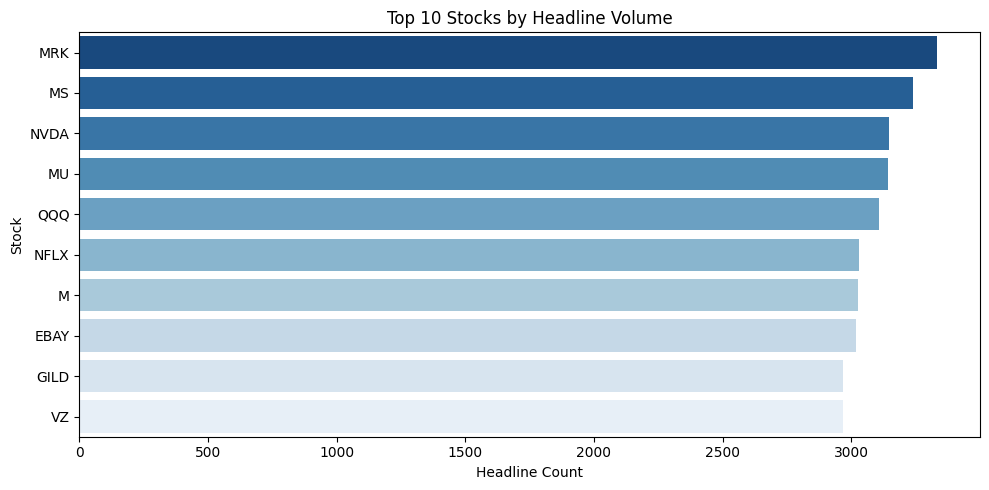

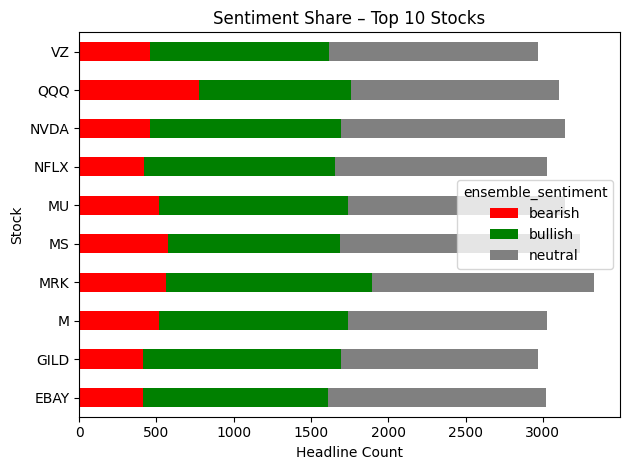

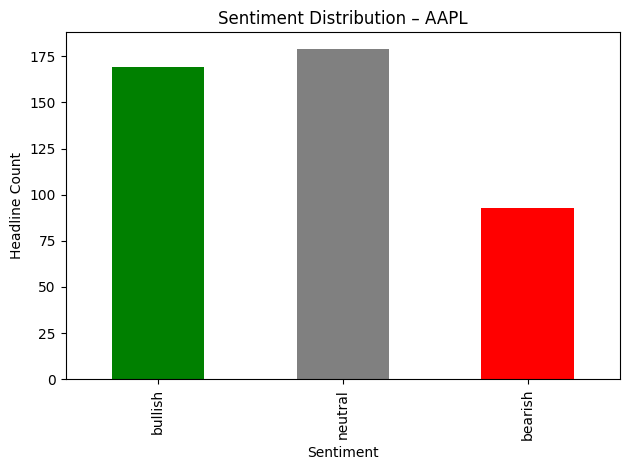

✅ StockVolatilityAnalyzer initialized with 1407328 rows.
✅ StockVolatilityAnalyzer instance created.


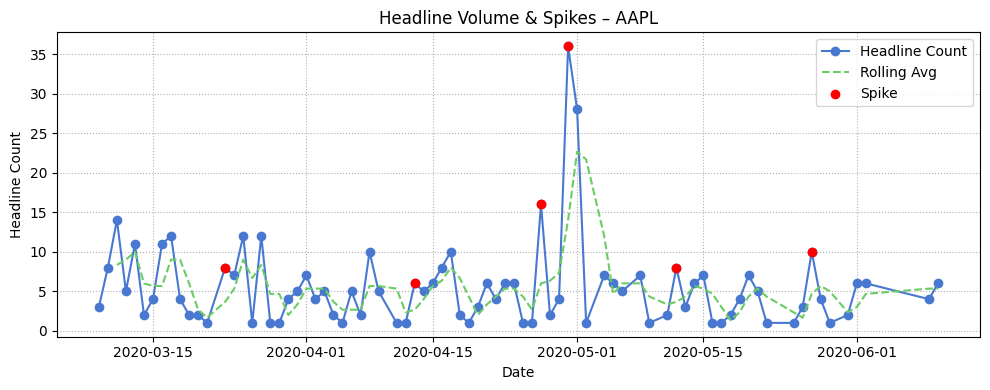

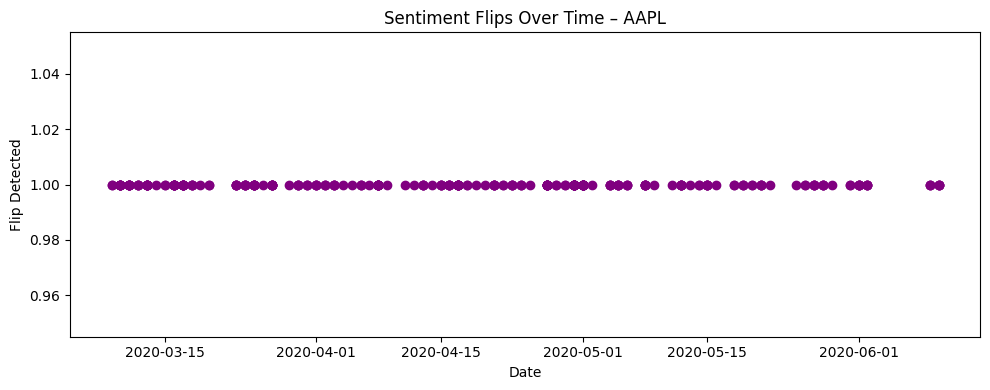

In [83]:
# ------------------------------------------------------------------------------------------
# 📈 Full Stock-Level Diagnostic Pipeline – Sentiment + Event Merge + Volume + Volatility
# ------------------------------------------------------------------------------------------

from src.text_stock_eda import (
    StockHeadlineProfiler,
    StockVolatilityAnalyzer,
)

try:
    # Step 1: Initialize stock-level headline profiler
    try:
        profiler = StockHeadlineProfiler(df, verbose=True)
        print("✅ StockHeadlineProfiler instance created.")
    except Exception as e:
        raise RuntimeError(f"Failed to initialize StockHeadlineProfiler: {e}")

    # Step 2: Get headline volume per stock
    try:
        volume_df = profiler.get_headline_volume()
        print("✅ Headline volume computation completed.")
    except Exception as e:
        raise RuntimeError(f"Headline volume computation failed: {e}")

    # Step 3: Compute sentiment distribution per stock
    try:
        sentiment_df = profiler.get_sentiment_distribution()
        print("✅ Sentiment distribution computation completed.")
    except Exception as e:
        raise RuntimeError(f"Sentiment distribution computation failed: {e}")

    # Step 4: Optional – Merge with event data if available
    try:
        if "event_phrase_df" in locals():
            merged_df = profiler.join_with_events(event_phrase_df)
            print("✅ Merged with event data.")
        else:
            print("⚠️ Event data not found in scope. Skipping event merge.")
    except Exception as e:
        raise RuntimeError(f"Event merge failed: {e}")

    # Step 5: Optional – Visualize top N stocks by volume
    try:
        profiler.plot_top_stocks_by_volume(n=10)
    except Exception as e:
        print(f"⚠️ Volume visualization failed: {e}")

    # Step 6: Optional – Visualize top N stocks by sentiment share
    try:
        profiler.plot_sentiment_share_by_stock(n=10)
    except Exception as e:
        print(f"⚠️ Sentiment share visualization failed: {e}")

    # Step 7: Optional – Plot sentiment distribution for a selected stock
    try:
        profiler.plot_sentiment_distribution(stock="AAPL")  # 🔁 Change ticker as needed
    except Exception as e:
        print(f"⚠️ Sentiment distribution plot failed: {e}")

    # Step 8: Initialize volatility analyzer
    try:
        volatility_analyzer = StockVolatilityAnalyzer(df, verbose=True)
        print("✅ StockVolatilityAnalyzer instance created.")
    except Exception as e:
        raise RuntimeError(f"Failed to initialize StockVolatilityAnalyzer: {e}")

    # Step 9: Plot volume spike timeline for a stock
    try:
        volatility_analyzer.plot_volume_spikes(
            stock="AAPL"
        )  # 🔁 Change ticker as needed
    except Exception as e:
        print(f"⚠️ Volume spike plot failed: {e}")

    # Step 10: Optional – Plot sentiment flips over time
    try:
        volatility_analyzer.plot_sentiment_flips(
            stock="AAPL"
        )  # 🔁 Change ticker as needed
    except Exception as e:
        print(f"⚠️ Sentiment flip timeline failed: {e}")

except Exception as e:
    print(f"❌ Full stock-level pipeline failed: {e}")

In [84]:
# ------------------------------------------------------------------------------
# 💾 Export Final Enriched Dataset for Task 2
# ------------------------------------------------------------------------------
from datetime import datetime

# Define output directory and filename with timestamp
output_dir = "data/exports"
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
filename = f"news_sentiment_enriched_{timestamp}.csv"
output_path = os.path.join(output_dir, filename)

try:
    # Export the enriched DataFrame
    df.to_csv(output_path, index=False)
    print(f"✅ Exported enriched dataset to: {output_path}")
except Exception as e:
    print(f"❌ Failed to export enriched dataset: {e}")

✅ Exported enriched dataset to: data/exports\news_sentiment_enriched_20250601_2017.csv


In [ ]:
df